# Let's implement the famous Attention is All You Need

## by Abu Huzaifah Bidin

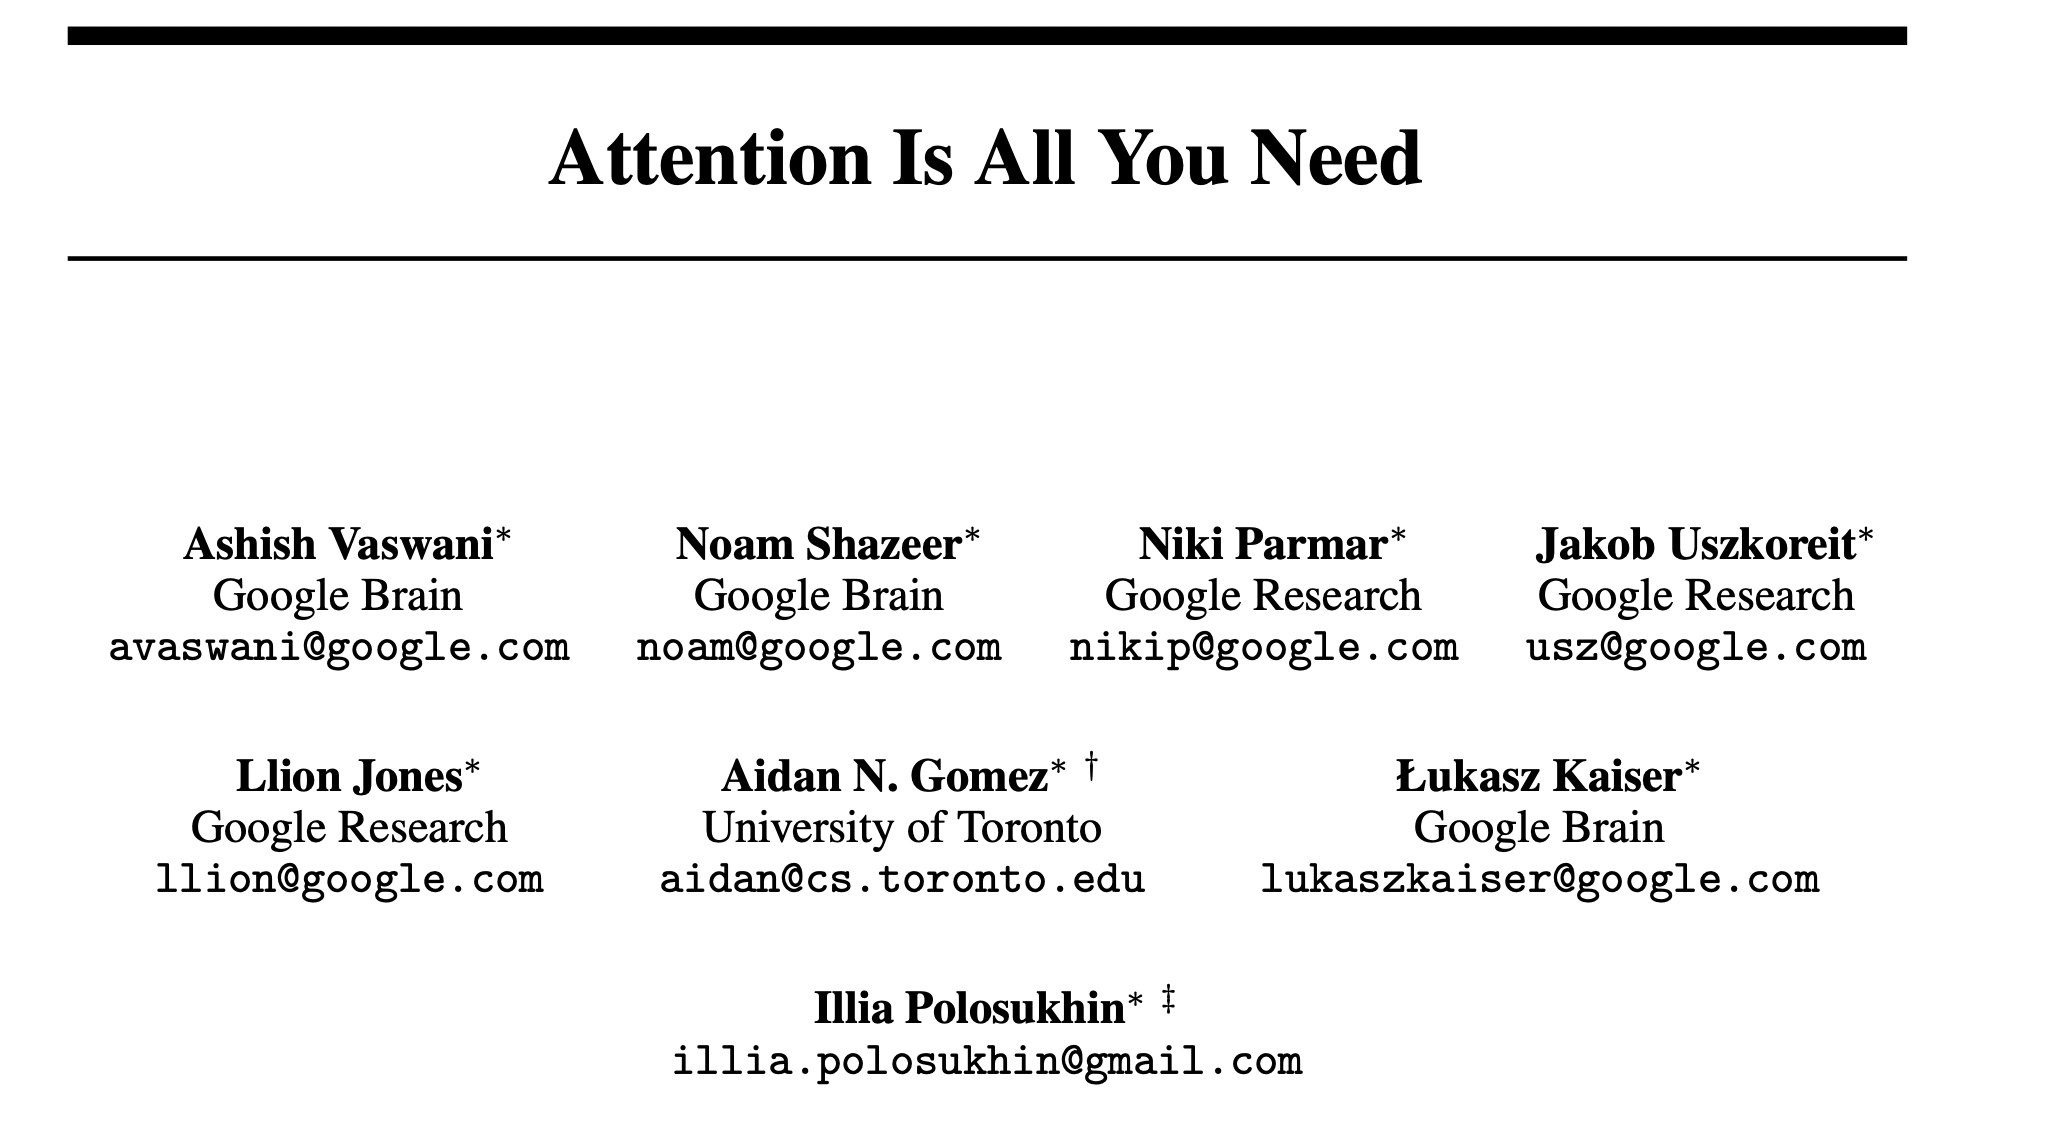

### Here's the Abstract of the paper

The dominant sequence transduction models are based on **complex recurrent or convolutional neural networks** that include an **encoder** and a decoder. The best performing models also **connect the encoder and decoder** through an **attention
mechanism**. We propose a new **simple network architecture**, the **Transformer**,
based **solely on attention mechanisms**, **dispensing** with **recurrence and convolutions**
entirely. **Experiments** on two machine translation tasks show these models to
be superior in quality while being more parallelizable and requiring significantly
**less time to train*8. Our model achieves **28.4 BLEU on the WMT 2014 English-
to-German translation task**, improving over the existing best results, including
ensembles, by over 2 BLEU. On the **WMT 2014 English-to-French translation task,
our model establishes a new single-model state-of-the-art BLEU score of 41.8** after
training for 3.5 days on eight GPUs, a small fraction of the training costs of the
best models from the literature. We show that the **Transformer generalizes well** to
other tasks by applying it successfully to English constituency parsing both with
large and limited training data.

### What we can learn from the Abstract?
1. Previous dominant model are either complex RNN or CNN.
2. But they include encoder and decoder for translation works
3. This encoder decoder are connected through attention mechanism. Previously attention mechanism are only seen as addition to the complex Seq2seq model.
4. They proposes totally new model, ditching the RNN and CNN architecture for total attention mechanism. They called it transformer
5. The transformer was tested with two machine translation task, **French** and **German** to **English**. Both scored higher than then leading model.
6. In order to replicate that paper, we will perform the translation task using **English to Malay translation**

### Objective of our experiment
1. To build a full transformer model and understand how it works
2. To pass and train the model on malay to english translation.
3. To get the BLEU(Bilingual Evaluation Understudy) score of our translation and compare with original paper

**Let's begin!!**

### Part 1: Understanding the Architecture
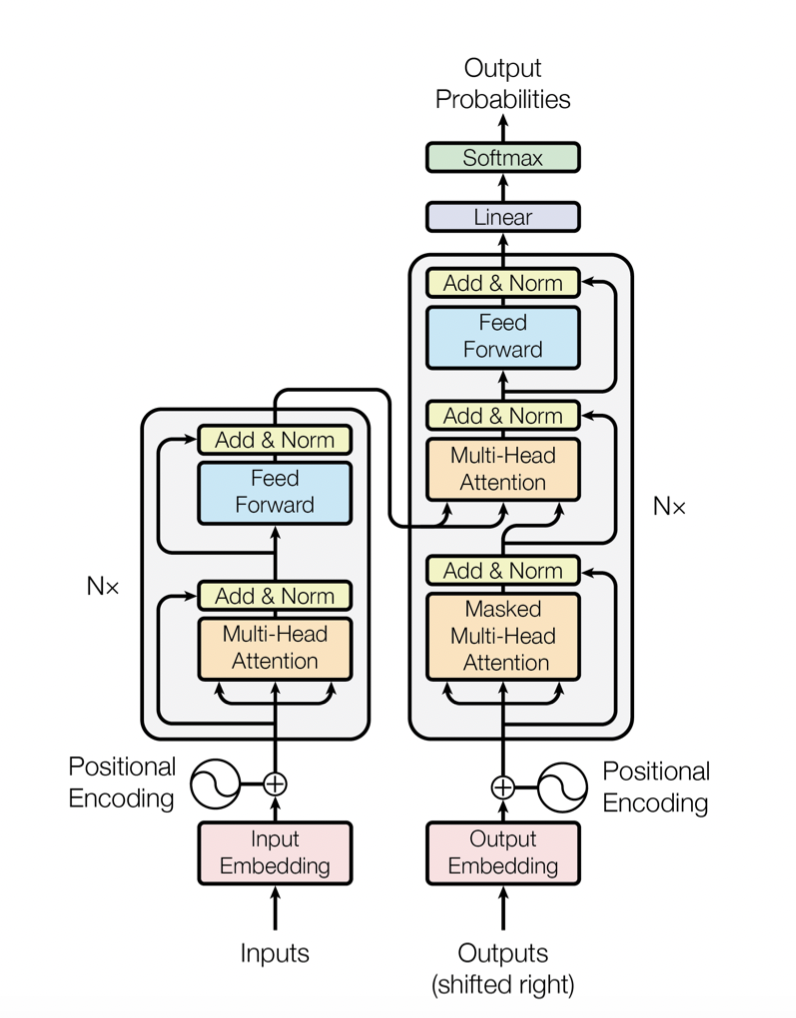

The image above is kinda scary (still is) for me who has no basics. But if we know what to look for, we can understand the transformer architecture completely. As as srart, let's separate two sections of the transformer, the left (which is the encoder) and the right (which is the decoder).

**Encoder-decoder architecture**
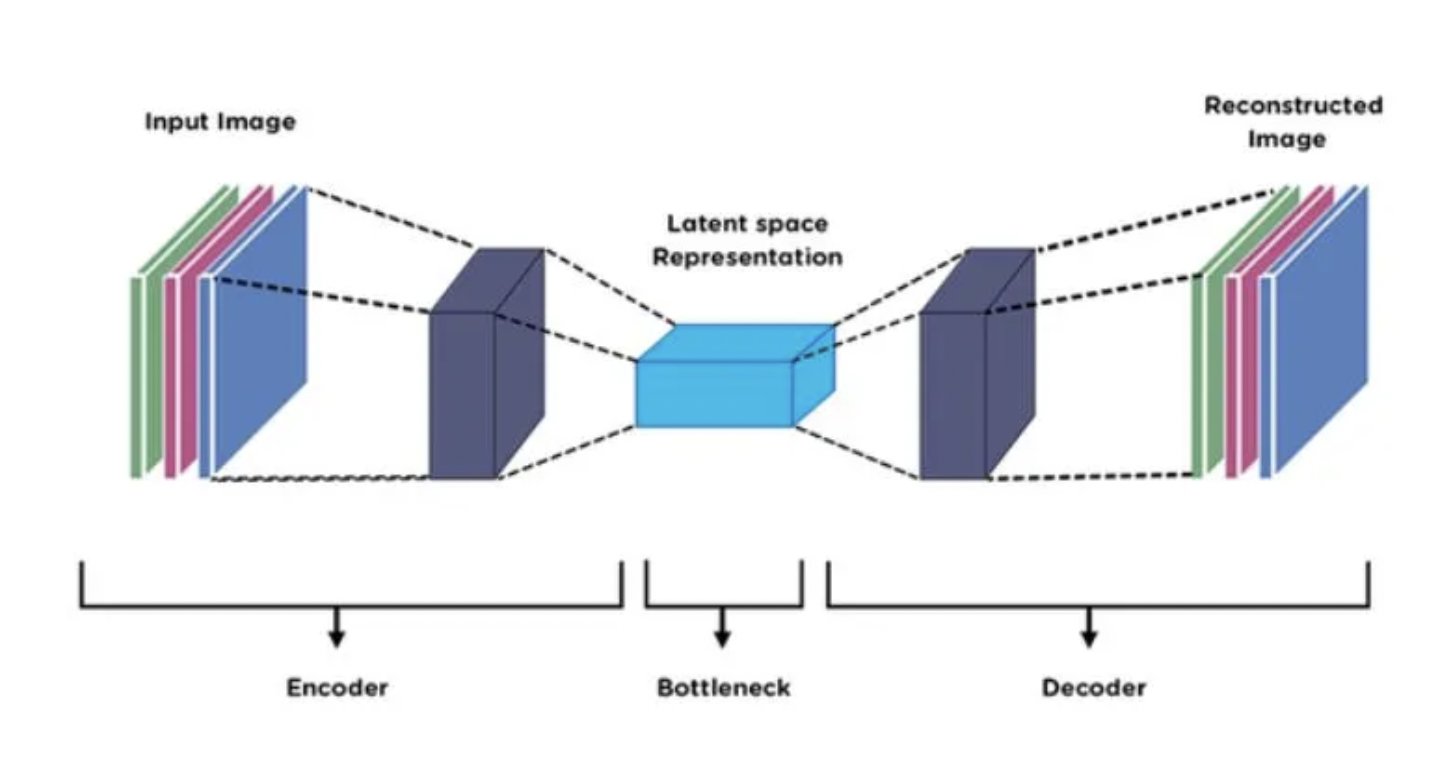

This is the picture that I see is easier for people to understand what is encoder decoder architecture. Although it uses image for example, it has basically the same structure. In the picture we see that encoder change the input into rich-context representation that is easier to be learn by machine. The training is done on this rich-context representation. The decoder then change the rich-context representation back to image or original input. So, the goal is to have the rich-context representation done properly so that when it is decoder, all the context will not disappear and we will get the correct output.


**Encoder part**
So, we will start with encoding the encoder part first. It starts with input embedding, followed by positional encoding, followed by multihead attention, addition and normalization, then goes to a feed forward network and lastly finishing off with addition and normalization layer. So, let's do that

In [1]:
# let's import the library, we will use pytorch
import torch
import torch.nn as nn #for neural network 
import math #for mathematical operations

**Input Embedding**
Alright, let's do the input embedding. Input embedding change the input into a tensor (vector with multiple dimensions). We can set the number of dimensions by using pytorch function, nn.Embeddings. This is the documentation of that function

>"A simple lookup table that stores embeddings of a fixed dictionary and size.
This module is often used to store word embeddings and retrieve them using indices. The input to the module is a list of indices, and the output is the corresponding word embeddings."

In the past I have extensively talked about tokenization. Ths is different from input embeddings. Embeddings change it to vector, tokenization change it to just numbers. Why we need tokenization in the first place? Because we need to eliminate the need to have large dimensions for embeddings. By using efficient algorithms like BPE or sentence-piece we can reduce the numbers of dimensions needed since we're processing it by subwords instead of words.

Let's implement this input embedding


In [2]:
# Input Embedding layer for encoder
class InputEmbedding(nn.Module):
    """
    InputEmbedding class: Maps token indices to dense vectors of size (batch_size, sequence_length, d_model).
    
    Args:
        vocab_size (int): Size of the vocabulary.
        d_model (int): Dimension of the embedding vectors.
    
    Returns:
        Tensor: Embedded representation of input tokens with shape (batch_size, sequence_length, d_model).
     """
    def __init__(self,vocab_size,d_model):
        super(InputEmbedding,self).__init__()
        self.embedding = nn.Embedding (vocab_size,d_model) #we just use the embedding function from pytorch

    def forward(self,x):
        return self.embedding(x)


So that's basically it. We have create the layer for input embeddings. Now let's move on to positional encoding

**Positional-Encoding**
Ok, for me I think this is the more interesting aspect of this transformer (maybe not, but that's just my opinion). Because they propose to ditch the recurrent model altogether, they propose a method to allow for the model to understand the position of the words in a body of text. I think I have written about this extensively in this tutorial (in malay) 
https://medium.com/@maercaestro/siri-belajar-ai-mari-belajar-tentang-penanaman-posisi-positional-embedding-94ad4cdd7cc2

What we want is just the formula, which is here

The positional encoding for each position $ pos $ and each dimension $ i $ is defined as:

$$
PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)
$$
$$
PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)
$$

where $ pos $ is the position in the sequence, $ i $ is the dimension index, and $ d_{\text{model}} $ is the dimension of the embedding vectors.

**So let's implement this!!**

In [3]:
#positional encoding layer for encoder block
class PositionalEncoding(nn.Module):
    """
    Positional encoder class : add position information to our data coming from token embeddings to retain the sequence order

    Argument taken:
    d_model (int) : Dimensions of the embedding vectors
    max_len (int) : Maximum length of the input sequence


    Returns:
    Tensor : Input tensor with posisitonal encodings added, with shape (sequence_length, batch_size, d_model)
    This tensor won't be updated during training, so we will register is as buffer
    """
    def __init__(self,d_model,max_len = 5000):
        super(PositionalEncoding, self).__init__()
        #initialize the pe tensor first
        pe= torch.zeros (max_len, d_model)
        position = torch.arange(0, max_len, dtype= torch.float).unsqueeze(1) #the position of our embedding token
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model)) #the division
        pe[: , 0 :: 2] = torch.sin(position * div_term) #when the dimension number is even
        pe[:,  1 :: 2] = torch.cos(position * div_term) #when the dimension number is odd
        pe = pe.unsqueeze(0).transpose(0,1)
        self.register_buffer('pe', pe) #to ensure this number won't be updated during training

    def forward(self,x):
        x = x + self.pe[:x.size(0),:]
        return x

***Attention-Layer** : According to data scientists, this is actually the backbone of the transformer. Originally Seq2Seq model and LSTM  only used attention mechanism to improve upon their model. But this 8 Google Scientist propose to use the attention as the main backbone of the entire architecture. I also have written extensively on attention mechanism here 

https://medium.com/@maercaestro/siri-belajar-ai-mekanisma-perhatian-cd71853ec325

What I want to show is just the formula for Attention Mechanism. 

The attention mechanism can be expressed as:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) V
$$

Where:
- $ Q $ is the **Query** matrix.
- $ K $ is the **Key** matrix.
- $ V $ is the **Value** matrix.
- $ d_k $ is the dimension of the keys.
- The **softmax** function is applied to normalize the attention scores.

This formula computes the attention weights by taking the dot product of the query and key, scaling it by the square root of the key dimension, and applying softmax. These weights are then used to create a weighted sum of the values.

**Let's implement this!!**


The scaled dot product attention class is implemented as below

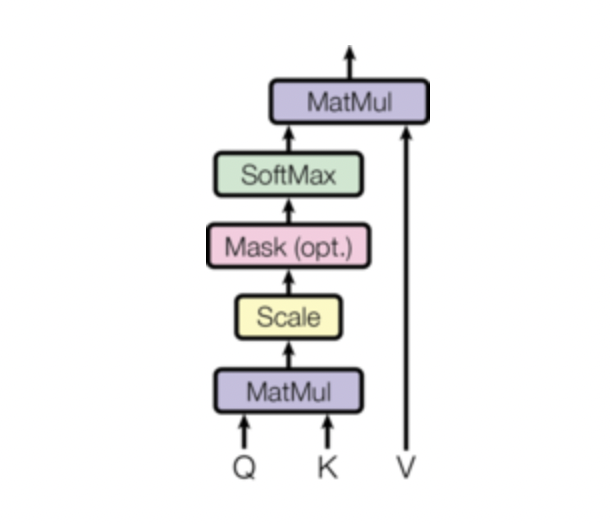

In [4]:
#let's build the attention layer for our decoder. start with scaleddotproduct attention class

class ScaledDotProductAttention(nn.Module):
    """
    This class computes attention scores for the input and outputs the weighted sum of values tensor

    Argument taken:

    query (tensor) = Query tensor of shape (batch_size , num_heads, sequence_length , d_k).
    key (tensor) = key tensor of shape (batch_size , num_heads, sequence_length , d_k).
    value (tensor) = key tensor of shape (batch_size , num_heads, sequence_length , d_k).
    mask (tensor, optional) = mask tensor to ignore certain positions with shape (batch_size, 1 ,sequence_length, sequence_length).

    returns:
    Tensor : output tensor after appying attention, shape ((batch_size , num_heads, sequence_length , d_k)
    """

    def __init__(self):
        super(ScaledDotProductAttention,self).__init__()


    def forward(self, query, key , value, mask = None):
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2,-1)) / math.sqrt(d_k) #this is the formula above
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9) #in case we want to apply masked. No need for encoder block
        attention = torch.softmax(scores, dim = -1) #apply softmax
        output = torch.matmul(attention,value)
        return output,attention

The multi head attention class is implemented as below:
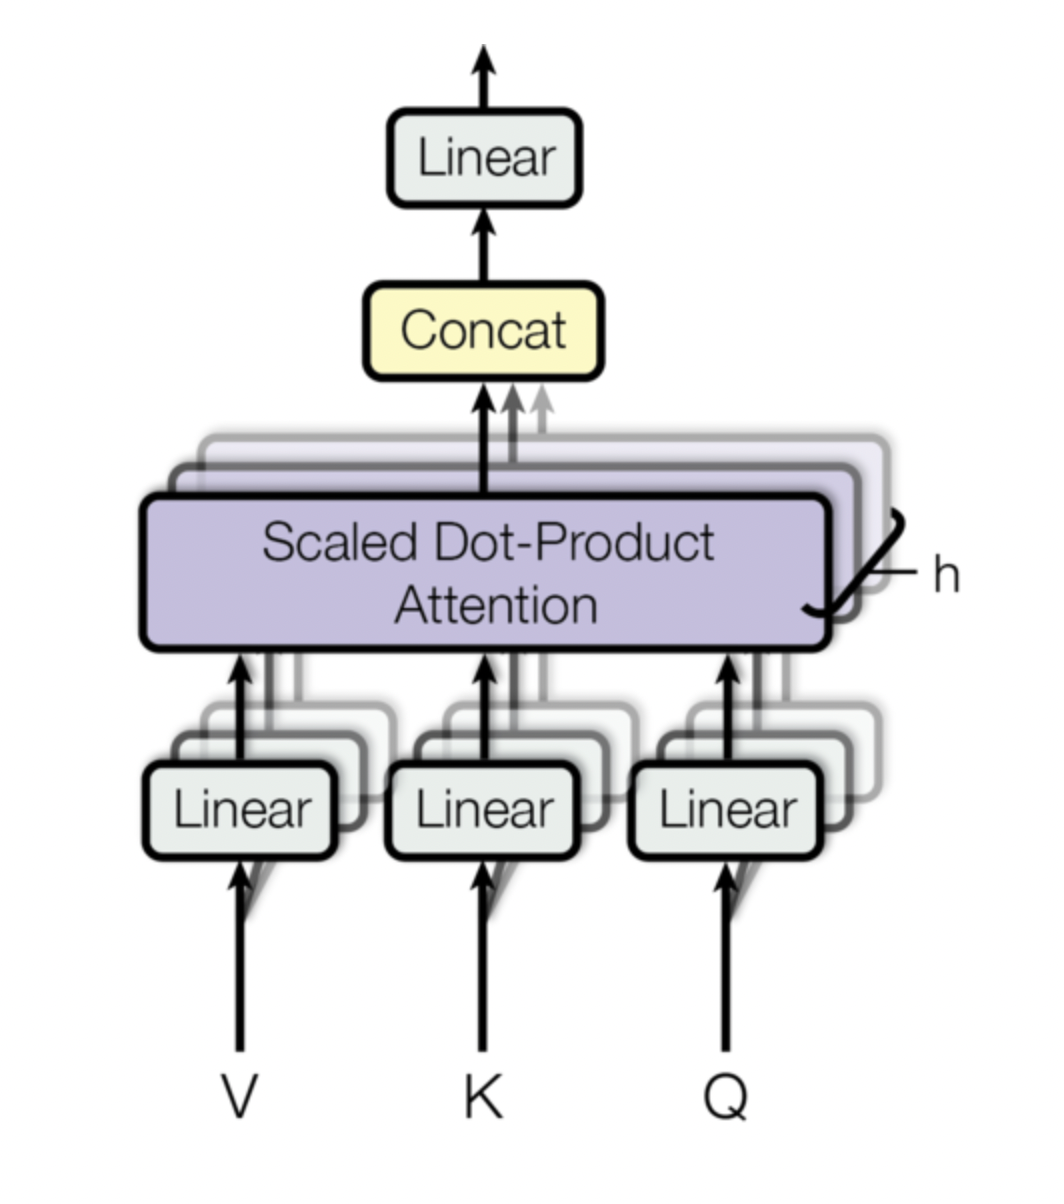

In [5]:
#now let's use that class for our multi head attention
class MultiHeadAttention(nn.Module):
    """
    This class implements multi-head attention by combining multiple scaled dot product attention modules

    Argument taken:
    h(int) : number of attention heads
    d_model (int) : dimension of the model

    returns:
    tensor: output tensor after concatenating attention frim all heads, shape (batch_size, sequence_length, d_model).

    """
    def __init__(self,h,d_model):
        super(MultiHeadAttention,self).__init__()
        assert d_model % h == 0 # to ensure all head attention to all dimensions
        self.d_k = d_model // h
        self.h = h
        self.linear_layers = nn.ModuleList([nn.Linear(d_model,d_model) for _ in range(4)]) #create 4 linear layers, like the picture below
        self.attention = ScaledDotProductAttention() 
        self.dropout = nn.Dropout(p = 0.1) #apply dropout to the linear layer if required to prevent overfitting


    def forward (self,query,key,value, mask=None):
        batch_size = query.size(0)
        query, key, value = [l(x).view(batch_size, -1, self.h, self.d_k).transpose(1,2) #apply linear transformation for all three k,q,v linear layers
                            for l,x in zip(self.linear_layers, (query,key,value))]
        x, attn = self.attention(query, key, value, mask = mask)
        x= x.transpose(1,2).contiguous().view(batch_size, -1 ,self.h * self.d_k) #prepare for concatenation
        return self.linear_layers[-1](x) #return everything to original d_model dimensions

**Feed-forward Network**
Now is the easy part. We have to pass the output from the multi-head attention to the traditional feed forward neural network. This is basically a simple neural network with 2 layers with ReLU activation function between them. I've also written extensively on the neural network. You can find it here

https://medium.com/@maercaestro/siri-belajar-ai-mari-buat-jaringan-neural-dari-kosong-b525ba11171c

Pytorch has already a built-in function to build a fully connected neural network, so this will be easy.

In [6]:
#build the feedforward network in our encoder block
class FeedForwardNetwork(nn.Module):
    """
    This class applies two linear transformations with a ReLU activation function in between

    Argument taken:
    d_model (int) : Dimension of the model
    d_ff (int): Dimension of the feed-forward layer

    returns: 
    Tensor: Output tensor after the feed forward network, shape (batch_size, sequence_length, d_model).

    """

    def __init__(self, d_model , d_ff = 2048):
        super(FeedForwardNetwork , self).__init__()
        self.linear1 = nn.Linear(d_model,d_ff) #the first layer, changing the dimensions from 512 to 2048
        self.linear2 = nn.Linear(d_ff, d_model) # the second layer, changing back the dimensions to 512
        self.relu = nn.ReLU() #the ReLU activation functions
        self.dropout = nn.Dropout(p=0.1) 

    def forward(self,x):
        return self.linear2(self.dropout(self.relu(self.linear1(x))))

So, we have all the basic building blocks for our encoder block. We can create a full layer and build the total block. Let's do that

In [7]:
#the encoder layer, combining all parts that we have build previously
class EncoderLayer(nn.Module):
    """
    This class represents a single layer of the transformer encoder

    Arguments:
    d_model (int) : Dimension of the model
    h (int) : number of attention heads
    d_ff (int) : Dimension of the feed forward layer
    dropout (float) :dropout probability of 0.1

    returns:
    tensor : output tensor after the encoder layer, shape (batch_size, sequence_length, d_model).

    """

    def __init__(self, d_model, h, d_ff, dropout = 0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(h, d_model) #the attention part
        self.ffn = FeedForwardNetwork(d_model, d_ff) #the feedforward network
        self.norm_layers =nn.ModuleList([nn.LayerNorm(d_model) for _ in range(2)]) #don't forget to normnalize after attention and FFN
        self.dropout = nn.ModuleList([nn.Dropout(dropout) for _ in range(2)]) #add dropout after each sublayer



    def forward(self, x, src_mask=None):
        # Self-Attention Layer
        x = self.norm_layers[0](x + self.dropout[0](self.self_attn(x, x, x, src_mask)))
        
        # Feed Forward Layer
        x = self.norm_layers[1](x + self.dropout[1](self.ffn(x)))
        
        return x


In [8]:
#and lastly we combine all this layer, including the token embedding and positional embedding to form the entire encoder block
class Encoder(nn.Module):
    """
    The entire encoder block class combining multiple encoder layers and the token and positional embeddings

    argument taken :
    num_layers (int): number of encoder layers
    d_model (int) : dimension of the model
    h (int) : number of attention heads
    d_ff (int): dimension of the feed roward layer
    vocab_size (int) : maximum length of the input sequence
    dropout (float) : dropout probability

    returns:
    tensor: output tensor after the encoder with shape (batch_size, sequence_length,d_model).
    """

    def __init__(self, num_layers, d_model, h, d_ff, vocab_size, max_len, dropout=0.1):
        super(Encoder, self).__init__()
        self.input_embedding = InputEmbedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList([EncoderLayer(d_model, h, d_ff, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, src_mask=None):
        x = self.input_embedding(x)
        x = self.pos_encoding(x)
        x = self.dropout(x)  # Apply dropout to the sum of embeddings and positional encodings
        for layer in self.layers:
            x = layer(x, src_mask)
        return self.norm(x)
        

In [9]:
# Example usage of Encoder
num_layers = 6  # Number of encoder layers
vocab_size = 10000  # Vocabulary size
max_len = 100  # Maximum sequence length

# Encoder
encoder = Encoder(num_layers=num_layers, d_model=512, h=8, d_ff=2048, vocab_size=vocab_size, max_len=max_len)
x = torch.randint(0, vocab_size, (32, 100))  # Example input (batch_size, sequence_length)
enc_output= encoder(x)
print(enc_output.shape)  # Should output torch.Size([32, 100, 512])

torch.Size([32, 100, 512])


Alright, our encoder block works. Let's move on to our decoder block

**Decoder-Block**
Basically the decoder block only have slight difference with encoder block. They add another layer of multi head attention which is the masked multi-head attention. The masked component is what allowed it to be auto-regressive, meaning that it would predict the next token (word) based on information provided in the previous token (word). This is the component that OpenAI takes to form ChatGPT. Yeah, chatGPT is the decoder-only transformer model. So, since we have every module/building blocks, let's build the decoder block

In [10]:
#build the individual decoder layer first
class DecoderLayer(nn.Module):
    """
    This layer represnts single layer of the transformer decoder

    Argument taken: 
    d_model (int) : Dimension of the model
    h (int) : Number of attention heads
    d_ff (int) : Dimension of the feed-forward layer
    dropout (float) : dropout probability

    returns:
    tensor : output tensor after decoder layer with shape (batch_size, sequence_length, d_model).
    """
    def __init__(self, d_model, h, d_ff, dropout = 0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(h, d_model)
        self.enc_dec_attn = MultiHeadAttention(h, d_model)
        self.ffn = FeedForwardNetwork(d_model, d_ff)
        self.norm_layers = nn.ModuleList([nn.LayerNorm(d_model) for _ in range(3)])
        self.dropout = nn.ModuleList([nn.Dropout(dropout) for _ in range(3)])


    def forward(self,x, enc_output, tgt_mask = None, memory_mask = None):
        #masked self attention
        x = self.norm_layers[0](x + self.dropout[0](self.self_attn(x,x,x,tgt_mask)))

        #encoder-decoder attention layer
        x = self.norm_layers[1](x+ self.dropout[1](self.enc_dec_attn(x, enc_output,enc_output,memory_mask)))

        #feedforward layer
        x = self.norm_layers[2](x + self.dropout[2](self.ffn(x)))


        return x

In [11]:
# Step 8: Decoder
class Decoder(nn.Module):
    """
    Decoder class: Represents the entire Transformer decoder with multiple decoder layers.
    
    Args:
        num_layers (int): Number of decoder layers.
        d_model (int): Dimension of the model.
        h (int): Number of attention heads.
        d_ff (int): Dimension of the feed-forward layer.
        vocab_size (int): Size of the vocabulary.
        max_len (int): Maximum length of the input sequence.
        dropout (float): Dropout probability.
    
    Returns:
        Tensor: Output tensor after the decoder, shape (batch_size, sequence_length, d_model).
    """
    def __init__(self, num_layers, d_model, h, d_ff, vocab_size, max_len, dropout=0.1):
        super(Decoder, self).__init__()
        self.token_embedding = InputEmbedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList([DecoderLayer(d_model, h, d_ff, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, enc_output, tgt_mask=None, memory_mask=None):
        x = self.token_embedding(x)
        x = self.pos_encoding(x)
        x = self.dropout(x)  # Apply dropout to the sum of embeddings and positional encodings
        for layer in self.layers:
            x = layer(x, enc_output, tgt_mask, memory_mask)
        return self.norm(x)

In [12]:
#now let's build the decoder block
class Decoder(nn.Module):
    """
    This is the entire decoder block

    argument taken:
    num_layers (int) : Number of decoder layers
    d_model (int) : dimension of the model
    h(int) : number of attention heads
    d_ff (int) : dimension of the feed=forward layer
    vocab_size (int) : size of the vocabulary
    max_len (int) : maximum length of the input sequence
    dropout (float) : dropout probability

    returns:
    tensor: output tensor after the decoder with shape (batch_size, sequence_length, d_model)
    """

    def __init__(self, num_layers, d_model, h, d_ff, vocab_size, max_len, dropout = 0.1):
        super(Decoder, self).__init__()
        self.input_embedding = InputEmbedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList([DecoderLayer(d_model, h, d_ff, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)


    def forward (self, x, enc_output, tgt_mask = None , memory_mask = None):
        x = self.input_embedding(x)
        x = self.pos_encoding(x)
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x,enc_output,tgt_mask, memory_mask)

        return self.norm(x)

In [13]:
# Example usage of Decoder
num_layers = 6  # Number of decoder layers
vocab_size = 10000  # Vocabulary size
max_len = 100  # Maximum sequence length

decoder = Decoder(num_layers=num_layers, d_model=512, h=8, d_ff=2048, vocab_size=vocab_size, max_len=max_len)
x = torch.randint(0, vocab_size, (32, 100))  # Example input (batch_size, sequence_length)
enc_output = torch.randn(32, 100, 512)  # Example encoder output
dec_output = decoder(x, enc_output)
print(dec_output.shape)  # Should output torch.Size([32, 100, 512])

torch.Size([32, 100, 512])


Yes. Both my encoder and decoder block works perfectly.Let's combine both of these blocks and form a complete transformer as incepted in the paper

**Transformer Complete Architecture**


In [14]:
class Transformer(nn.Module):
    """
    Transformer class: Represents the complete Transformer model with encoder and decoder.
    
    Args:
        num_layers (int): Number of encoder and decoder layers.
        d_model (int): Dimension of the model.
        h (int): Number of attention heads.
        d_ff (int): Dimension of the feed-forward layer.
        src_vocab_size (int): Size of the source vocabulary.
        tgt_vocab_size (int): Size of the target vocabulary.
        max_len (int): Maximum length of the input sequence.
        dropout (float): Dropout probability.
    
    Returns:
        Tensor: Output tensor after the Transformer, shape (batch_size, sequence_length, d_model).
    """
    def __init__(self, num_layers, d_model, h, d_ff, src_vocab_size, tgt_vocab_size, max_len, dropout=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, h, d_ff, src_vocab_size, max_len, dropout)
        self.decoder = Decoder(num_layers, d_model, h, d_ff, tgt_vocab_size, max_len, dropout)
        self.output_layer = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, memory_mask=None):
        enc_output = self.encoder(src, src_mask)
        dec_output = self.decoder(tgt, enc_output, tgt_mask, memory_mask)
        return self.output_layer(dec_output)

In [15]:
#the full transformer architecture
class Transformer(nn.Module):
    """
    Complete transformer class

    argument taken:
    num_layers (int) : number of encoder and decoder layers
    d_model (int) : dimension of the model
    h (int) : number of attention heads
    d_ff (int) : dimension of the feed-forward layer
    src_vocab_size (int) : size of the source vocabulary
    tgt_vocab_size (int) : size of the target vocabulary

    max_len (int) : maximum length of the input sequence
    dropout (float) : dropout probability

    returns:
    tensor: output tensor after the transformer with the shape (batch_size, sequence_length, d_model).

    """
    def __init__(self, num_layers, d_model, h , d_ff, src_vocab_size, tgt_vocab_size, max_len ,dropout = 0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, h, d_ff, src_vocab_size, max_len, dropout)
        self.decoder = Decoder(num_layers, d_model, h, d_ff, src_vocab_size, max_len, dropout)
        self.output_layer = nn.Linear(d_model, tgt_vocab_size)


    def forward(self,src,tgt,src_mask = None, tgt_mask = None , memory_mask = None):
        enc_output = self.encoder (src, src_mask)
        dec_output = self.decoder (tgt, enc_output, tgt_mask, memory_mask)
        return torch.softmax(self.output_layer(dec_output), dim=-1)
        



In [16]:
# Example usage of Transformer
num_layers = 6  # Number of encoder and decoder layers
src_vocab_size = 10000  # Source vocabulary size
tgt_vocab_size = 10000  # Target vocabulary size
max_len = 100  # Maximum sequence length

tf_model = Transformer(num_layers=num_layers, d_model=512, h=8, d_ff=2048, src_vocab_size=src_vocab_size, tgt_vocab_size=tgt_vocab_size, max_len=max_len)
src = torch.randint(0, src_vocab_size, (32, 100))  # Example source input (batch_size, sequence_length)
tgt = torch.randint(0, tgt_vocab_size, (32, 100))  # Example target input (batch_size, sequence_length)
tf_output = tf_model(src, tgt)
print(tf_output.shape)  # Should output torch.Size([32, 100, tgt_vocab_size])


torch.Size([32, 100, 10000])


torch.Size([1, 24, 512])


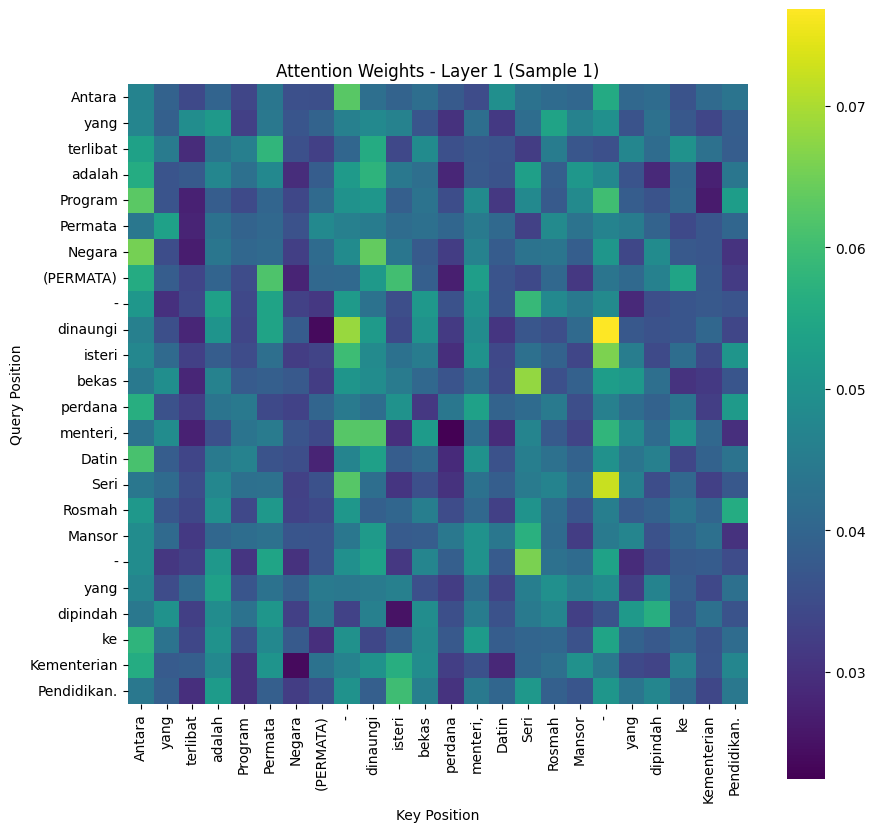

torch.Size([1, 18, 512])


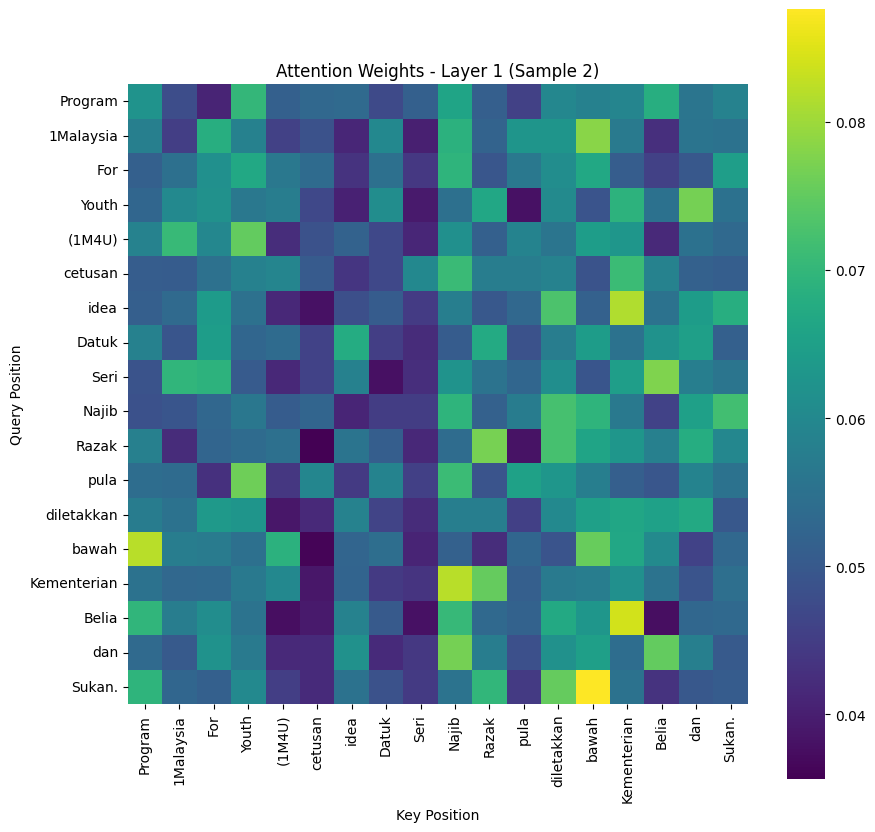

In [17]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 0: Token Embedding
class TokenEmbedding(nn.Module):
    """
    TokenEmbedding class: Maps token indices to dense vectors of size (batch_size, sequence_length, d_model).
    
    Args:
        vocab_size (int): Size of the vocabulary.
        d_model (int): Dimension of the embedding vectors.
    
    Returns:
        Tensor: Embedded representation of input tokens with shape (batch_size, sequence_length, d_model).
    """
    def __init__(self, vocab_size, d_model):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        return self.embedding(x)

# Step 1: Positional Encoding
class PositionalEncoding(nn.Module):
    """
    PositionalEncoding class: Adds positional information to token embeddings to retain sequence order.
    
    Args:
        d_model (int): Dimension of the embedding vectors.
        max_len (int): Maximum length of the input sequence.
    
    Returns:
        Tensor: Input tensor with positional encodings added, shape (sequence_length, batch_size, d_model).
    """
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        # Create a matrix of shape (max_len, d_model) to store positional encodings
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x

# Step 2: Scaled Dot-Product Attention
class ScaledDotProductAttention(nn.Module):
    """
    ScaledDotProductAttention class: Computes attention scores and outputs weighted sum of values.
    
    Args:
        query (Tensor): Query tensor of shape (batch_size, num_heads, sequence_length, d_k).
        key (Tensor): Key tensor of shape (batch_size, num_heads, sequence_length, d_k).
        value (Tensor): Value tensor of shape (batch_size, num_heads, sequence_length, d_k).
        mask (Tensor, optional): Mask tensor to ignore certain positions, shape (batch_size, 1, sequence_length, sequence_length).
    
    Returns:
        Tensor: Output tensor after applying attention, shape (batch_size, num_heads, sequence_length, d_k).
    """
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, query, key, value, mask=None):
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attention = torch.softmax(scores, dim=-1)
        output = torch.matmul(attention, value)
        return output, attention

# Step 3: Multi-Head Attention
class MultiHeadAttention(nn.Module):
    """
    MultiHeadAttention class: Implements multi-head attention by combining multiple scaled dot-product attention modules.
    
    Args:
        h (int): Number of attention heads.
        d_model (int): Dimension of the model.
    
    Returns:
        Tensor: Output tensor after concatenating attention from all heads, shape (batch_size, sequence_length, d_model).
    """
    def __init__(self, h, d_model):
        super(MultiHeadAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(4)])
        self.attention = ScaledDotProductAttention()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        query, key, value = [l(x).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linear_layers, (query, key, value))]
        x, attn = self.attention(query, key, value, mask=mask)
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)
        return self.linear_layers[-1](x), attn

# Step 4: Feed Forward Network
class FeedForwardNetwork(nn.Module):
    """
    FeedForwardNetwork class: Applies two linear transformations with a ReLU activation in between.
    
    Args:
        d_model (int): Dimension of the model.
        d_ff (int): Dimension of the feed-forward layer.
    
    Returns:
        Tensor: Output tensor after feed-forward network, shape (batch_size, sequence_length, d_model).
    """
    def __init__(self, d_model, d_ff=2048):
        super(FeedForwardNetwork, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        return self.linear2(self.dropout(self.relu(self.linear1(x))))

# Step 5: Encoder Layer
class EncoderLayer(nn.Module):
    """
    EncoderLayer class: Represents a single layer of the Transformer encoder.
    
    Args:
        d_model (int): Dimension of the model.
        h (int): Number of attention heads.
        d_ff (int): Dimension of the feed-forward layer.
        dropout (float): Dropout probability.
    
    Returns:
        Tensor: Output tensor after the encoder layer, shape (batch_size, sequence_length, d_model).
    """
    def __init__(self, d_model, h, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(h, d_model)
        self.ffn = FeedForwardNetwork(d_model, d_ff)
        self.norm_layers = nn.ModuleList([nn.LayerNorm(d_model) for _ in range(2)])
        self.dropout = nn.ModuleList([nn.Dropout(dropout) for _ in range(2)])

    def forward(self, x, src_mask=None):
        # Self-Attention Layer
        x_attn, attn = self.self_attn(x, x, x, src_mask)
        x = self.norm_layers[0](x + self.dropout[0](x_attn))
        
        # Feed Forward Layer
        x_ffn = self.ffn(x)
        x = self.norm_layers[1](x + self.dropout[1](x_ffn))
        
        return x, attn

# Step 6: Encoder
class Encoder(nn.Module):
    """
    Encoder class: Represents the entire Transformer encoder with multiple encoder layers.
    
    Args:
        num_layers (int): Number of encoder layers.
        d_model (int): Dimension of the model.
        h (int): Number of attention heads.
        d_ff (int): Dimension of the feed-forward layer.
        vocab_size (int): Size of the vocabulary.
        max_len (int): Maximum length of the input sequence.
        dropout (float): Dropout probability.
    
    Returns:
        Tensor: Output tensor after the encoder, shape (batch_size, sequence_length, d_model).
    """
    def __init__(self, num_layers, d_model, h, d_ff, vocab_size, max_len, dropout=0.1):
        super(Encoder, self).__init__()
        self.token_embedding = TokenEmbedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList([EncoderLayer(d_model, h, d_ff, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x, src_mask=None, return_attentions=False):
        x = self.token_embedding(x)
        x = self.pos_encoding(x)
        x = self.dropout(x)  # Apply dropout to the sum of embeddings and positional encodings
        attentions = []
        for layer in self.layers:
            x, attn = layer(x, src_mask)
            if return_attentions:
                attentions.append(attn)
        x = self.norm(x)
        if return_attentions:
            return x, attentions
        return x

# Visualization Function
def visualize_attention(attn, tokens, title="Attention Weights"):
    # attn shape: (batch_size, num_heads, sequence_length, sequence_length)
    avg_attn = attn.mean(dim=1)[0].detach().numpy()  # Take the average across heads for the first example in the batch
    plt.figure(figsize=(10, 10))
    sns.heatmap(avg_attn, cmap='viridis', cbar=True, square=True, xticklabels=tokens, yticklabels=tokens)
    plt.title(title)
    plt.xlabel("Key Position")
    plt.ylabel("Query Position")
    plt.show()

# Load CSV file
csv_file = "dataset/combined_dataset.csv"  # Update with the path to your CSV file
df = pd.read_csv(csv_file)

# Select the first two rows from the dataset
for sample_idx in range(2):
    source_text = df.loc[sample_idx, 'source_text']
    translated_text = df.loc[sample_idx, 'translated_text']

    # Tokenization (simple whitespace splitting for demonstration)
    source_tokens = source_text.split()
    translated_tokens = translated_text.split()

    # Create a vocabulary based on the tokens
    vocab = list(set(source_tokens + translated_tokens))
    vocab_size = len(vocab)
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}

    # Convert tokens to indices
    source_indices = [word_to_idx[token] for token in source_tokens]

    # Example usage of Encoder
    num_layers = 6  # Number of encoder layers
    d_model = 512  # Dimension of the model
    max_len = 100  # Maximum sequence length

    # Encoder
    encoder = Encoder(num_layers=num_layers, d_model=d_model, h=8, d_ff=2048, vocab_size=vocab_size, max_len=max_len)
    x = torch.tensor(source_indices).unsqueeze(0)  # Example input (batch_size=1, sequence_length)
    enc_output, attentions = encoder(x, return_attentions=True)
    print(enc_output.shape)  # Should output torch.Size([1, sequence_length, d_model])

    # Visualize attention from the first layer
    visualize_attention(attentions[0], tokens=source_tokens, title=f"Attention Weights - Layer 1 (Sample {sample_idx + 1})")
